#  Silent_Horizon
---

> A regime-aware ensemble model for short-term crypto price movement prediction using XGBoost.

### Description :


>  * We define **market regimes** using handcrafted signal strength metrics, known as `Signal_Simulators`.
>  * The dataset is then **partitioned** based on how well each data point aligns with these regimes.
>  * We train **6 regime-specialist XGBoost classifiers**, each focused on predicting future price direction under different market conditions.
>  * A final **Meta\_Model** is trained to combine predictions from these specialists, using both their outputs and signal strengths as inputs.
>  * For comparison, we also train a **Benchmark XGBoost model** using the entire dataset and full feature set, without any regime separation.

---

## Necessary Code

Get the necessary libraries

In [1]:
!pip install ta optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "colab"

Data Source : https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset file:", path)

Path to dataset file: /kaggle/input/bitcoin-historical-data


In [4]:
df = pd.read_csv(f"{path}/btcusd_1-min_data.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s", utc=True)

# June 2025
start = pd.Timestamp("2025-06-01", tz="UTC")
end = pd.Timestamp("2025-07-01", tz="UTC")
df = df[(df["Timestamp"] >= start) & (df["Timestamp"] < end)]
df = df.sort_values("Timestamp")

Smoothen the price

In [5]:
df['price'] = (df['Close'] + df['Open'])/2

## Features

In [6]:
from ta import momentum, trend, volatility, volume
from scipy.stats import skew, zscore

def get_features(df):
  features = pd.DataFrame(index=df.index)

  # Basic returns
  features['log_ret_1'] = np.log(df['price'].shift(1) / df['price'].shift(2))
  features['log_ret_3'] = np.log(df['price'].shift(1) / df['price'].shift(4))
  features['log_ret_5'] = np.log(df['price'].shift(1) / df['price'].shift(6))
  features['log_ret_7'] = np.log(df['price'].shift(1) / df['price'].shift(8))
  features['log_ret_9'] = np.log(df['price'].shift(1) / df['price'].shift(10))
  features['log_ret_11'] = np.log(df['price'].shift(1) / df['price'].shift(12))
  features['log_ret_13'] = np.log(df['price'].shift(1) / df['price'].shift(14))
  features['log_ret_15'] = np.log(df['price'].shift(1) / df['price'].shift(16))

  # Volatility
  features['volatility3_10'] = features['log_ret_3'].rolling(10).std()
  features['volatility3_20'] = features['log_ret_3'].rolling(20).std()
  features['volatility5_10'] = features['log_ret_5'].rolling(10).std()
  features['volatility5_20'] = features['log_ret_5'].rolling(20).std()

  # Momentum Indicators
  macd = trend.MACD(df['price'])
  features['MACD'] = macd.macd()

  # Stochastic
  stoch = momentum.StochasticOscillator(df['High'], df['Low'], df['Close'])
  Stoch_K = stoch.stoch()
  Stoch_D = stoch.stoch_signal()
  features['Stochastic'] = (Stoch_K - Stoch_D) / 100

  features['TSI'] = momentum.TSIIndicator(df['price']).tsi()
  features['Williams_%R'] = momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()
  features['Donchian_width_20'] = df['High'].rolling(10).max() - df['Low'].rolling(10).min()

  # Volume Features
  features['OBV_diff'] = volume.OnBalanceVolumeIndicator(df['price'], df['Volume']).on_balance_volume().diff()

  # Moving Averages, Trend Features
  features['MA_5'] = df['price'].rolling(5).mean()
  MA_10 = df['price'].rolling(10).mean()
  MA_20 = df['Close'].rolling(20).mean()

  features['Price_over_MA_20'] = df['Close'] / MA_20
  features['MA_slope_10'] = MA_10 - MA_10.shift(1)
  features['MA_strength'] = (df['Close'] - MA_20) / (features['volatility5_10'] + features['volatility5_20'])

  adx = trend.ADXIndicator(df['High'], df['Low'], df['Close'])
  features['ADX'] = adx.adx()
  features['+DI'] = adx.adx_pos()
  features['-DI'] = adx.adx_neg()

  # Bollinger Bands
  bb = volatility.BollingerBands(df['price'])
  bb_mid = bb.bollinger_mavg()
  features['BB_width'] = bb.bollinger_hband() - bb.bollinger_lband()
  features['BB_strength'] = ((df['price'] - bb_mid) / features['BB_width']).clip(-3, 3)

  # Price Structure
  features['Close_over_BB_mid'] = df['Close'] / bb_mid
  features['Close_over_BB_upper'] = df['Close'] / bb.bollinger_hband()

  vwap = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum()
  features['Close_over_VWAP'] = df['Close'] / vwap

  features['Support_bounce'] = (df['Low'] <= df['Low'].rolling(10).min()).astype(int)
  features['Range_compression_score'] = (features['BB_width'] - features['BB_width'].rolling(50).min()) / \
  (features['BB_width'].rolling(50).max() - features['BB_width'].rolling(50).min())

  return features

In [7]:
features = get_features(df)

## Signal_Indicators

In [8]:
# 1. RSI deviation from neutral (centered, normalized)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(50).mean()
avg_loss = loss.rolling(50).mean()
rs = avg_gain / (avg_loss + 1e-6)
df['sig_strength_rsi'] = 100 - (100 / (1 + rs))

# 2. MACD strength (MACD minus Signal Line)
macd = trend.MACD(df['price'])
df['sig_strength_macd'] = macd.macd_diff()

# 3. OBV momentum (z-scored OBV over 50 bars)
OBV = volume.OnBalanceVolumeIndicator(df['price'], df['Volume']).on_balance_volume()
df['sig_strength_obv'] = (OBV - OBV.rolling(50).mean()) / (OBV.rolling(50).std() + 1e-6)

# 4. VWAP reversion signal (percent deviation from VWAP)
vwap = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum()
df['sig_strength_vwap_reversion'] = (df['Close'] - vwap) / (vwap + 1e-6)

# 5. ROC momentum signal
df['sig_strength_roc'] = momentum.ROCIndicator(df['price'], window=10).roc() / 10

# 6. ADX strength signal (+DI - -DI), scaled by ADX itself
df['sig_strength_adx'] = (features['+DI'] - features['-DI'])

In [9]:
signals = ['sig_strength_rsi',
           'sig_strength_macd',
           'sig_strength_obv',
           'sig_strength_vwap_reversion',
           'sig_strength_roc',
           'sig_strength_adx']

strong_indices = []
specificity = 0.32

for signal in signals :
  df[signal] = (df[signal] - df[signal].mean())/df[signal].std() # Normalize for training
  thresh1,thresh2 = df[signal].quantile(specificity),df[signal].quantile(1-specificity)
  dfa = df[df[signal] < thresh1]
  dfb = df[df[signal] > thresh2]
  df3 = pd.concat([dfa,dfb])
  for t in df3['Timestamp'].values:
    strong_indices.append(t)

len(np.unique(strong_indices))/len(df)

0.9895601851851852

almost all of the market is covered by some of the other signal

In [10]:
import seaborn as sns

def plot_signal_vs_price(df, signal_col, horizon = 4):
    # Remove NaNs
    df = df[[signal_col, 'price']].dropna().copy()
    df['signal_strength'] = df[signal_col]
    future_mean = df['price'].shift(-horizon).rolling(horizon).mean()
    past_mean = df['price'].rolling(horizon).mean().shift(1)
    df['fut_ret'] = np.log(future_mean / past_mean)
    col = 'fut_ret'
    # Plot
    plt.figure(figsize=(12, 5))
    sns.scatterplot(data=df, x=col, y=signal_col, hue='signal_strength', palette='coolwarm', alpha=0.6)
    plt.title(f"{signal_col} vs {col} with Signal Hue")
    plt.xlabel(col)
    plt.ylabel(signal_col)
    plt.xlim(df[col].min(), df[col].max())
    plt.ylim(df[signal_col].min(), df[signal_col].max())
    plt.axvline(0, color='gray', linestyle='--')
    specificity = 0.32
    thresh1,thresh2 = df[signal_col].quantile(specificity),df[signal_col].quantile(1-specificity)
    plt.axhline(thresh1, color='cyan', linestyle='-.')
    plt.axhline(thresh2, color='pink', linestyle='-.')
    plt.show()

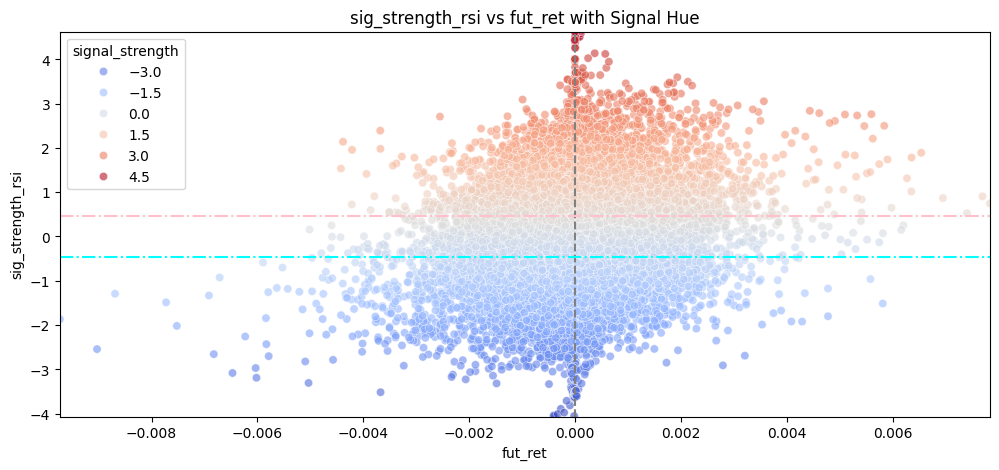

In [11]:
plot_signal_vs_price(df,signals[0])

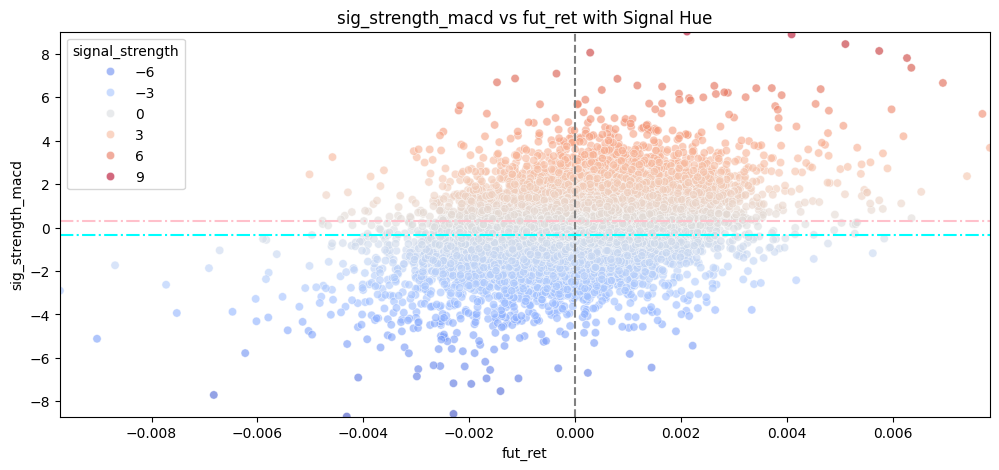

In [12]:
plot_signal_vs_price(df,signals[1])

In [13]:
def plot_with_signal_overlay(df, signal_col='sig_strength_macd', price_col='price', window=600):
    df = df[[price_col, signal_col]].dropna().copy()

    plt.figure(figsize=(12, 5))
    sc = plt.scatter(df.index[-window:], df[price_col].tail(window),
                     c=df[signal_col].tail(window), cmap='coolwarm', s=10)
    plt.colorbar(sc, label=signal_col)
    plt.title(f"{price_col} with {signal_col} overlay")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

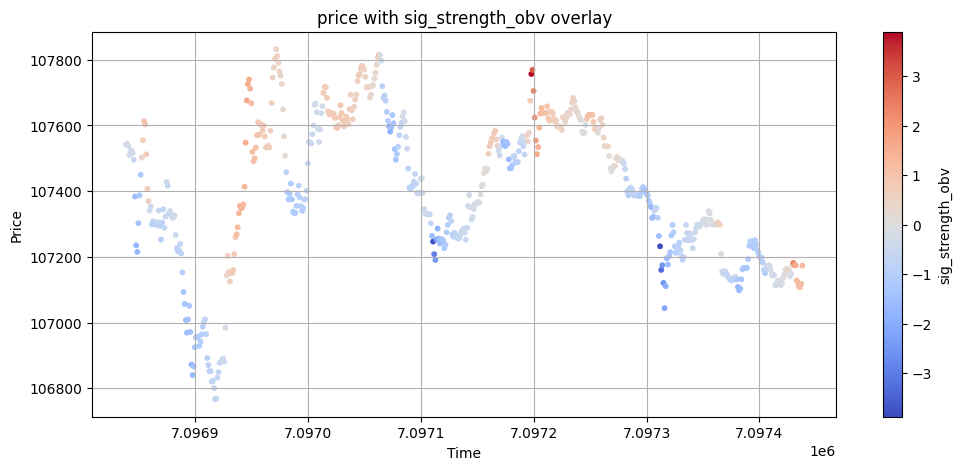

In [14]:
plot_with_signal_overlay(df, signal_col=signals[2])

## Regime Specialist Models

In [15]:
# XGBoost bagging trainer per signal

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

horizon=4
quantile=0.32
label_col = 'Target'
models = []

def analyse_and_train(signal_name):
    # 1. Partition strong parts of dataset based on signal
    low, high = df[signal_name].quantile(quantile), df[signal_name].quantile(1 - quantile)
    strong_mask = (df[signal_name] < low) | (df[signal_name] > high)

    # Get matching features and df slice using the same index
    X_strong = features.loc[strong_mask].copy()
    df_strong = df.loc[strong_mask].copy()

    # 2. Compute non-leaky forward return
    future_mean = df_strong['price'].shift(-horizon).rolling(horizon).mean()
    past_mean = df_strong['price'].rolling(horizon).mean().shift(1)
    df_strong['fut_ret'] = np.log(future_mean / past_mean)
    df_strong['fut_ret'] = (df_strong['fut_ret'] - df_strong['fut_ret'].mean())/df_strong['fut_ret'].std()

    # 3. Labeling
    threshold1 = df_strong['fut_ret'].quantile(0.2)
    threshold2 = df_strong['fut_ret'].quantile(0.8)
    df_strong[label_col] = np.where(df_strong['fut_ret'] < threshold1, -1,
                            np.where(df_strong['fut_ret'] > threshold2, 1, 0))

    # 4. Drop rows with NaNs (from rolling)
    valid_idx = df_strong.dropna(subset=['fut_ret', label_col]).index
    X = X_strong.loc[valid_idx]
    y = df_strong.loc[valid_idx, label_col]
    y = np.array(y)
    y = 1+y # 0 for SELL , 1 for HOLD , 2 for BUY

    # 6. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    SUM1 = len(y_train)
    SUM = len(y_test)

    # 7. Train XGB Classifier
    model = XGBClassifier(n_estimators=170, max_depth=4, learning_rate=0.002, use_label_encoder=True, verbosity = 0, eval_metric='mlogloss')
    model.fit(X_train, y_train)

    # 8. Predict & Evaluate
    y_pred = model.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    tag = signal_name[13:16]
    print(f"Train {tag} | Accuracy: {acc:.4f} | Positives: {sum(y_pred==2)/SUM1:.4f}, Negatives: {sum(y_pred==0)/SUM1:.4f}, Neutral: {sum(y_pred==1)/SUM1:.4f}")

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"  ✅ {tag} | Accuracy: {acc:.4f} | Positives: {sum(y_pred==2)/SUM:.4f}, Negatives: {sum(y_pred==0)/SUM:.4f}, Neutral: {sum(y_pred==1)/SUM:.4f}")

    # 9. Store model
    models.append((signal_name, model))


In [16]:
for signal in signals:
  analyse_and_train(signal)

Train rsi | Accuracy: 0.6872 | Positives: 0.1197, Negatives: 0.1446, Neutral: 0.7357
  ✅ rsi | Accuracy: 0.7948 | Positives: 0.0739, Negatives: 0.0715, Neutral: 0.8546
Train mac | Accuracy: 0.6951 | Positives: 0.1072, Negatives: 0.1139, Neutral: 0.7790
  ✅ mac | Accuracy: 0.7167 | Positives: 0.0878, Negatives: 0.0845, Neutral: 0.8277
Train obv | Accuracy: 0.6937 | Positives: 0.1099, Negatives: 0.1374, Neutral: 0.7527
  ✅ obv | Accuracy: 0.7675 | Positives: 0.0768, Negatives: 0.0857, Neutral: 0.8376
Train vwa | Accuracy: 0.6931 | Positives: 0.1444, Negatives: 0.1604, Neutral: 0.6952
  ✅ vwa | Accuracy: 0.8251 | Positives: 0.0637, Negatives: 0.0516, Neutral: 0.8848
Train roc | Accuracy: 0.6914 | Positives: 0.0923, Negatives: 0.1175, Neutral: 0.7902
  ✅ roc | Accuracy: 0.7196 | Positives: 0.0765, Negatives: 0.0888, Neutral: 0.8346
Train adx | Accuracy: 0.6994 | Positives: 0.1200, Negatives: 0.1447, Neutral: 0.7353
  ✅ adx | Accuracy: 0.7903 | Positives: 0.0743, Negatives: 0.0740, Neutral:

### Checks for data leak

| Aspect                     | Observation                                                                                 | Verdict   |
| -------------------------- | ------------------------------------------------------------------------------------------- | --------- |
| **fut\_ret computation**   | You used `shift(-H).rolling(H).mean()` for future and `rolling(H).mean().shift(1)` for past | ✅ Correct |
| **Signal usage**           | You dropped `signal_name` from features used in model                                       | ✅ Correct |
| **Feature frame**          | You used `features.loc[mask]` separately from `df.loc[mask]`                                | ✅ Correct |
| **Train-test split**       | `shuffle=False` used (important for time series data)                                       | ✅ Correct |
| **Label balance**          | Class distribution varies across signals, not always 50/50                                  | ✅ Good    |
| **Test accuracy is lower** | Models perform slightly worse on test set → no data leakage                                 | ✅ Pass    |

✅ Conclusion: There is no sign of data leakage in your pipeline. You're doing things properly and rigorously.

In [17]:
len(models)

6

In [18]:
X = features.values

In [19]:
for i in range(0,len(models)):
    y = models[i][1].predict(X)
    print(models[i][0], round(sum(y==0)/len(y),3) , round(sum(y==1)/len(y),3) , round(sum(y==2)/len(y),3))

sig_strength_rsi 0.121 0.773 0.105
sig_strength_macd 0.078 0.848 0.074
sig_strength_obv 0.111 0.793 0.096
sig_strength_vwap_reversion 0.127 0.751 0.122
sig_strength_roc 0.082 0.857 0.062
sig_strength_adx 0.103 0.811 0.087


most of the predictions are HOLD

In [20]:
def plot_model_signals_with_strength(model_tuple, features, df,
                                               window_minutes=240, offset_minutes=120, lookback=1000):
    signal_name, model = model_tuple
    signal_strength_col = signal_name

    # Predict
    X = features.iloc[lookback:].values
    y_pred = model.predict(X)

    # Align predictions with df
    df2 = pd.DataFrame({
        'pred': y_pred,
        'Price': df['price'].iloc[lookback:].reset_index(drop=True),
        'Timestamp': df['Timestamp'].iloc[lookback:].reset_index(drop=True),
        'Strength': df[signal_strength_col].iloc[lookback:].reset_index(drop=True)
    })

    df2['Direction'] = df2['pred'].map({2: 'BUY', 0: 'SELL', 1: 'HOLD'})

    # Subset recent window
    t_end = df2['Timestamp'].max() - pd.Timedelta(minutes=offset_minutes)
    t_start = t_end - pd.Timedelta(minutes=window_minutes)
    plot_df = df2[(df2['Timestamp'] >= t_start) & (df2['Timestamp'] <= t_end)].reset_index(drop=True)

    # Split predictions
    buy = plot_df[plot_df['pred'] == 2]
    sell = plot_df[plot_df['pred'] == 0]
    hold = plot_df[plot_df['pred'] == 1]

    # Calculate horizontal line for baseline hue strip
    price_floor = plot_df['Price'].min() - 100
    strength_y = [price_floor] * len(plot_df)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 5))

    # Background signal strength hue strip (horizontal)
    norm = plt.Normalize(plot_df['Strength'].min(), plot_df['Strength'].max())
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(norm(plot_df['Strength']))
    ax.scatter(plot_df['Timestamp'], strength_y, color=colors, s=15, alpha=0.8, label='Signal Strength Strip')

    # Price line
    ax.plot(plot_df['Timestamp'], plot_df['Price'], color='black', linewidth=1.2, label='Close Price')

    # Model decisions
    ax.scatter(buy['Timestamp'], buy['Price'], color='green', marker='^', s=50, alpha=0.6, label='BUY (↑)')
    ax.scatter(sell['Timestamp'], sell['Price'], color='red', marker='v', s=50, alpha=0.6, label='SELL (↓)')
    ax.scatter(hold['Timestamp'], hold['Price'], color='grey', marker='o', s=35, alpha=0.4, label='HOLD (•)')

    # Labels and formatting
    ax.set_title(f"{signal_name.upper()} Model Decisions with Signal Strength (Baseline Strip)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label(f"{signal_strength_col}")

    plt.tight_layout()
    plt.show()

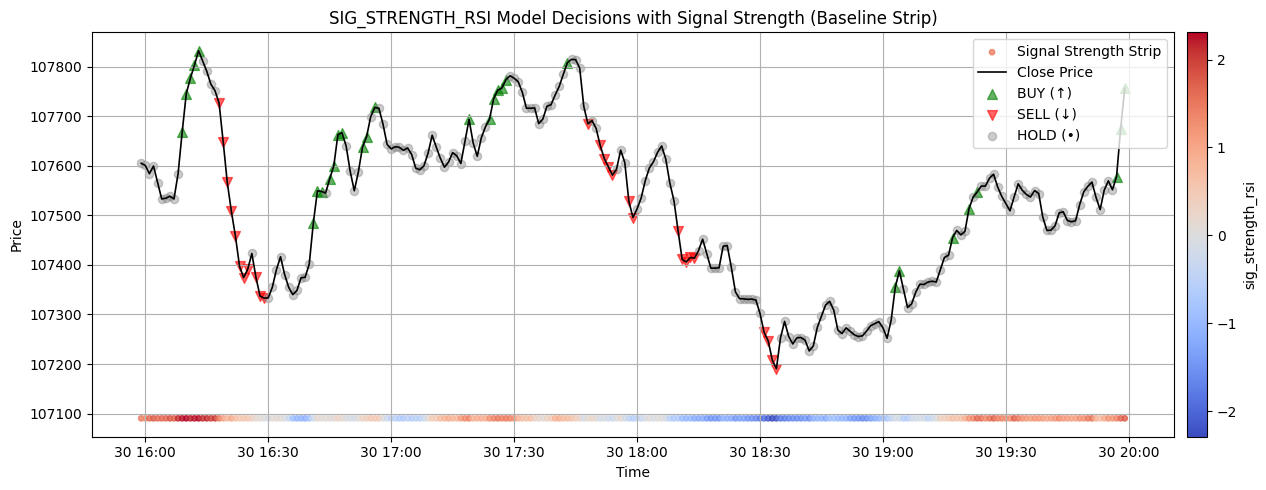

In [21]:
T = 240
plot_model_signals_with_strength(models[0], features, df,
                                 window_minutes=240, offset_minutes=T)

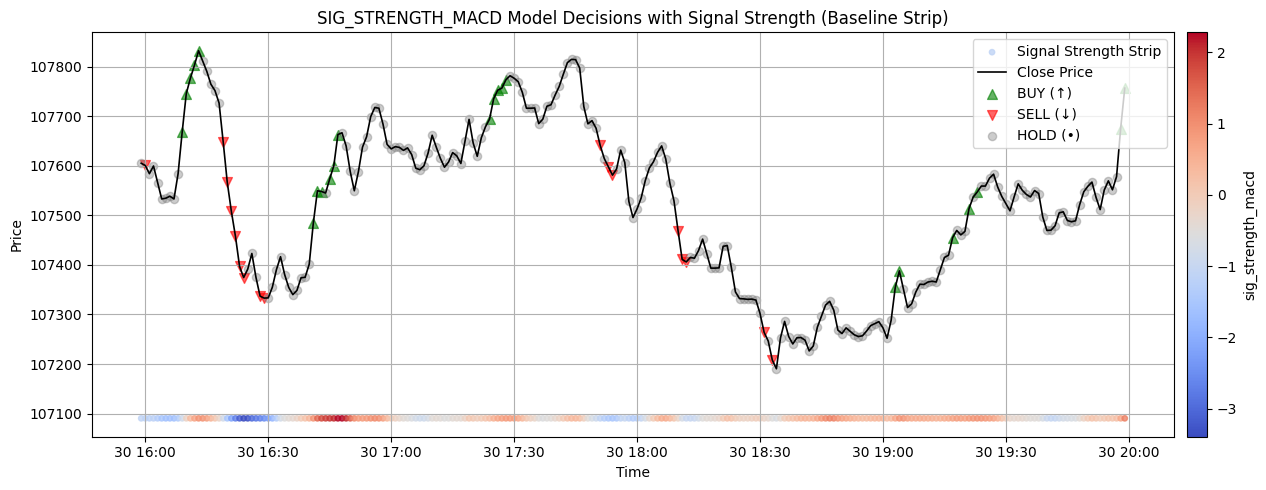

In [22]:
plot_model_signals_with_strength(models[1], features, df,
                                 window_minutes=240, offset_minutes=T)

 We avert any risks created by false positives by training the models to detect only the strongest 20% buy and sell predictions.

Let's Normalise the signals for training the Meta Model

In [23]:
df_signals = df[signals].copy()
for signal in signals:
  df_signals[signal] = (df_signals[signal] - df_signals[signal].mean())/df_signals[signal].std()

### Targets for meta model

In [24]:
horizon = 4
future_mean = df['price'].shift(-horizon).rolling(horizon).mean()
past_mean = df['price'].rolling(horizon).mean().shift(1)
future_returns = np.log(future_mean / past_mean)

threshold1 = future_returns.quantile(0.2)
threshold2 = future_returns.quantile(0.8)
targets = np.where(future_returns > threshold2, 1 ,
            np.where(future_returns < threshold1, -1 , 0))
np.mean(np.abs(targets))

np.float64(0.3999537037037037)

In [25]:
df_signals['Target'] = targets
df_signals.dropna(inplace=True)

## Features for the meta model

In [26]:
X_features = features.tail(30000).copy().reset_index(drop=True).values     # shape: (30000, 40)

In [27]:
model_preds = []

for signal_name, model in models:
    pred = model.predict(X_features)  # shape: (30000,)
    model_preds.append(pred.reshape(-1, 1))

model_preds = np.hstack(model_preds)  # shape: (30000, 9)

### Final Data Processing

In [28]:
X_meta_all = np.hstack([X_features, model_preds])  # shape: (30000, 40 + 9 = 49)

In [29]:
y_meta = df_signals.tail(30000)['Target'].values + 1  # shape: (30000,)

## Training

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_meta_all, y_meta, test_size=0.2, shuffle=False)

meta_model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.03,
                           objective='multi:softmax', num_class=3, eval_metric='mlogloss')

meta_model.fit(X_train, y_train)

# Not saving yet

y_pred_train = meta_model.predict(X_train)
y_pred_test = meta_model.predict(X_test)

print("📊 Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("📊 Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nTest Class Distribution:\n", pd.Series(y_pred_test).map({0:'SELL',1:'HOLD',2:'BUY'}).value_counts())

📊 Train Accuracy: 0.742875
📊 Test Accuracy: 0.8248333333333333

Test Class Distribution:
 HOLD    5095
SELL     462
BUY      443
Name: count, dtype: int64


In [31]:
import shap

# Original feature names from your DataFrame
original_feature_names = features.columns.tolist()

# Final feature names for SHAP
meta_feature_names = original_feature_names + signals

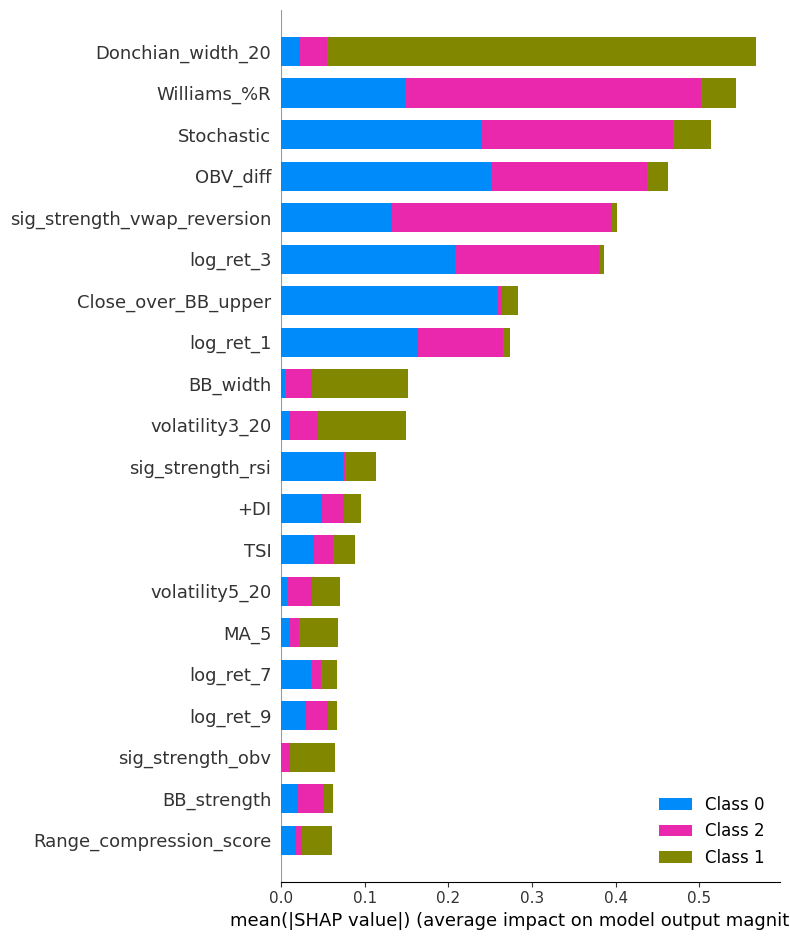

In [32]:
explainer = shap.Explainer(meta_model)
shap_values = explainer(X_test)

# Summary plot — shows overall feature contribution
shap.summary_plot(shap_values, X_test, feature_names=meta_feature_names)

## Comparison with a basic XGBoost Model

In [33]:
X_2 = features.iloc[49:].values
y = df_signals['Target'].values
y = y + 1

X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, shuffle=False)

model_0 = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.03,
                           objective='multi:softmax', num_class=3, eval_metric='mlogloss')

model_0.fit(X_train, y_train)

models.append(('benchmark_model', model_0))

y_pred_train = model_0.predict(X_train)
y_pred_test = model_0.predict(X_test)

print("📊 Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("📊 Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nTest Class Distribution:\n", pd.Series(y_pred_test).map({0:'SELL',1:'HOLD',2:'BUY'}).value_counts())

📊 Train Accuracy: 0.7510139049826188
📊 Test Accuracy: 0.7958521608156645

Test Class Distribution:
 HOLD    6843
BUY      927
SELL     861
Name: count, dtype: int64


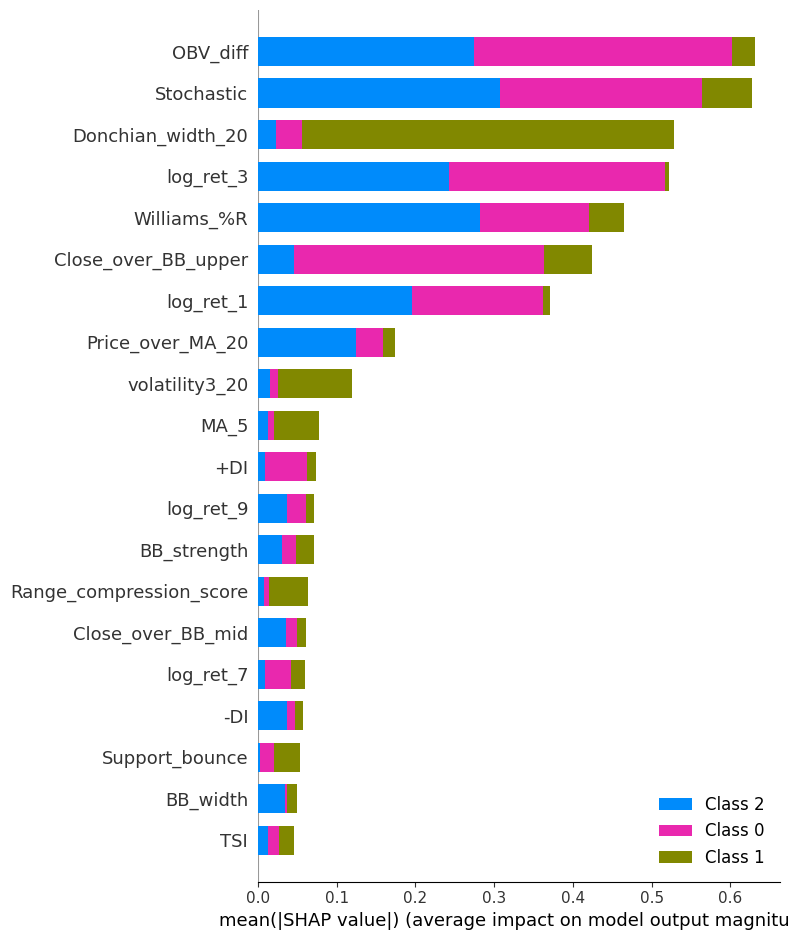

In [34]:
explainer = shap.Explainer(model_0)
shap_values = explainer(X_test)

# Summary plot — shows overall feature contribution
shap.summary_plot(shap_values, X_test, feature_names=original_feature_names)

## HP_Tuning

one final, best push we can make to our model

In [35]:
import optuna
%matplotlib inline
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit

X_train, X_test, y_train, y_test = train_test_split(X_meta_all, y_meta, test_size=0.2, shuffle=False)

# ✅ Objective function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 4, 4),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "objective": "multi:softmax",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "use_label_encoder": False,
        "verbosity": 0,
    }

    model = XGBClassifier(**params)

    tscv = TimeSeriesSplit(n_splits=5)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_tr, y_tr, verbose=False)
        y_pred = model.predict(X_val)

        score = accuracy_score(y_val, y_pred)
        scores.append(score)

        trial.report(score, step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(scores)

# ✅ Run Optuna Study
optuna.logging.set_verbosity(optuna.logging.WARNING)
pruner = MedianPruner(n_warmup_steps=3)
sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=100, show_progress_bar=True)

# ✅ Show best results
print("✅ Best Val Accuracy:", study.best_value)
print("🧠 Best Training Parameters:\n", study.best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

✅ Best Val Accuracy: 0.71315
🧠 Best Training Parameters:
 {'n_estimators': 298, 'max_depth': 4, 'learning_rate': 0.03007241787563577, 'subsample': 0.6754714119857358, 'colsample_bytree': 0.7037026203599133, 'gamma': 3.6065650304255144, 'min_child_weight': 3}


In [36]:
import optuna.visualization as vis

# Optimization History
vis.plot_optimization_history(study)

Majority of the models give an accuracy > 82% 🎉

Implying stability and not just a chance of luck

In [37]:
vis.plot_param_importances(study)

In [38]:
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

models.append(('best_meta_model', best_model))

print("📊 Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("📊 Test Accuracy:", accuracy_score(y_test, y_pred_test))

📊 Train Accuracy: 0.734
📊 Test Accuracy: 0.8245


## Save all the Models

In [39]:
import os
import joblib

# Create a directory if not exists
os.makedirs("saved_models/regime_models", exist_ok=True)

# Save each model with its signal name
for signal_name, model in models:
    path = f"saved_models/regime_models/{signal_name}_xgb.pkl"
    joblib.dump(model, path)
    print(f"✅ Saved model: {path}")

✅ Saved model: saved_models/regime_models/sig_strength_rsi_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_macd_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_obv_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_vwap_reversion_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_roc_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_adx_xgb.pkl
✅ Saved model: saved_models/regime_models/benchmark_model_xgb.pkl
✅ Saved model: saved_models/regime_models/best_meta_model_xgb.pkl


## Conclusion

In this project, we built a **regime-aware ensemble trading strategy** using:
>- A rich set of **technical indicators** and handcrafted market signals,
>- Multiple **XGBoost classifiers**, each specialized for a distinct signal regime,
>- A meta-ensemble model that combines **raw features** and **model predictions** for final decision making.

Our approach achieved **better performance than benchmark XGBoost model** trained directly on raw features, while offering:

* Greater **interpretability** through signal-specific decision patterns,
* Modular **scalability** for real-time application or further research,
* A strong foundation for **alpha generation** based on multi-factor reasoning.

🔒 Data leakage was strictly avoided, and validation methods were designed to reflect **realistic future prediction scenarios**.

This work serves as a compelling demonstration of combining **traditional feature engineering**, **machine learning ensemble design**, and **signal-based regime modeling** — essential skills for quantitative trading and research roles.

> ✨ With thoughtful modeling, strategic evaluation, and a clear view of the market’s structure, machine learning in trading becomes not just viable — but powerful.

-----

## Backtesting

In [40]:
def simulate_smooth_position_pnll(df, position_col="position", price_col="price", initial_cash=None, smoothing=3):
    # Smooth the position signal
    smoothed_position = df[position_col].rolling(smoothing, min_periods=1).mean()

    # Compute position delta (change in position)
    delta_position = smoothed_position.diff().fillna(0)

    # Use the first price as base
    if initial_cash is None:
        initial_cash = df[price_col].iloc[0]

    # Cash update: sell = cash increases, buy = cash decreases
    cash = initial_cash - np.cumsum(delta_position * df[price_col])

    # Mark to market portfolio value
    mark_to_market = cash + smoothed_position * df[price_col]

    return mark_to_market

In [41]:
# Preparing data for backtest
X_0 = X_meta_all[-30000:]

# Predict
y_pred = best_model.predict(X_0)

In [42]:
# Align with last part of df
df_model = df[['price','Timestamp']].iloc[-len(y_pred):].copy()
df_model["target"] = y_pred
df_model.sort_values("Timestamp", inplace=True)
df_model = df_model.dropna()

In [43]:
def simulate_smooth_position_pnl(df):
    df = df.copy()

    cash = df["price"].iloc[0] # Initial Investment = Amt of money to buy 1 Bitcoin
    position = 0
    mark_to_market = []

    # Assume Market Orders
    for i in range(len(df)):
        target_pos = df["position"].iloc[i]
        price_now = df["price"].iloc[i]
        if(target_pos != position): # 0 / 1 / 2
            cash += position * price_now # come to neutral position
            position = target_pos
            cash -= target_pos * price_now
        price_now = df["price"].iloc[i]
        portfolio_value = cash + position * price_now
        mark_to_market.append(portfolio_value)

    return mark_to_market

In [44]:
def plot_smooth_target_vs_price(df):
    df = df.copy()
    df["position"] = np.where(df["target"] == 2, 1,
                       np.where(df["target"] == 0, -1, 0))
    # Backtest with smoothed positions
    df["mark_to_market"] = simulate_smooth_position_pnl(df)

    final_value = df["mark_to_market"].iloc[-1]
    final_multiplier = final_value / df["mark_to_market"].iloc[0]

    buy = df[df["position"] == 1]
    sell = df[df["position"] == -1]
    hold = df[df["position"] == 0]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

    sizes = ([50,30,0.4]) if(df.iloc[-1]['Timestamp']-df.iloc[0]['Timestamp'] < pd.Timedelta(days=2)) else([20,20,0.2])
    # Price chart
    ax1.plot(df["Timestamp"], df["price"], color="black", linewidth=1.2, label="Price")
    ax1.scatter(buy["Timestamp"], buy["price"], color="green", marker="^", s=sizes[0], alpha=0.5, label="BUY")
    ax1.scatter(sell["Timestamp"], sell["price"], color="red", marker="v", s=sizes[0], alpha=0.5, label="SELL")
    ax1.scatter(hold["Timestamp"], hold["price"], color="grey", marker="o", s=sizes[1], alpha=sizes[2], label="HOLD")
    ax1.set_ylabel("BTC Price")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f"Price Chart with Model Predictions over {df.iloc[-1]['Timestamp']-df.iloc[0]['Timestamp']}")

    # Portfolio Value chart
    ax2.plot(df["Timestamp"], df["mark_to_market"], color="blue", label="Portfolio Value (Mark-to-Market)")
    price_floor = df["mark_to_market"].min() - 0.0001 * df["mark_to_market"].max()
    ax2.set_title(f"Cumulative PnL (Final Return: {final_multiplier:.3f}×)")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Portfolio Value")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="upper left")

    plt.tight_layout()
    plt.show()
    print(f"Final strategy multiplier: {final_multiplier:.4f}×")

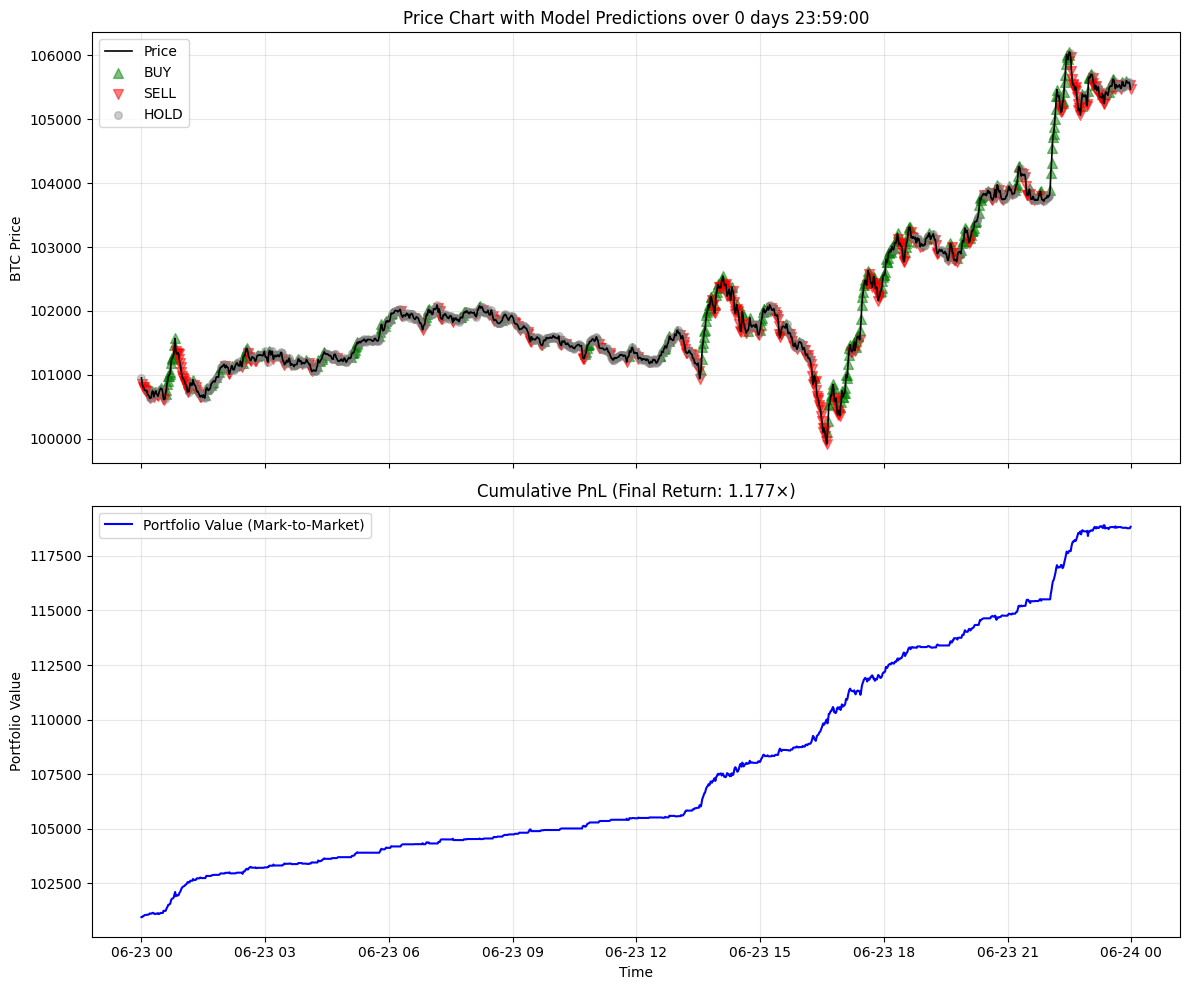

Final strategy multiplier: 1.1772×


In [45]:
plot_smooth_target_vs_price(df_model.iloc[-11520:-10080])

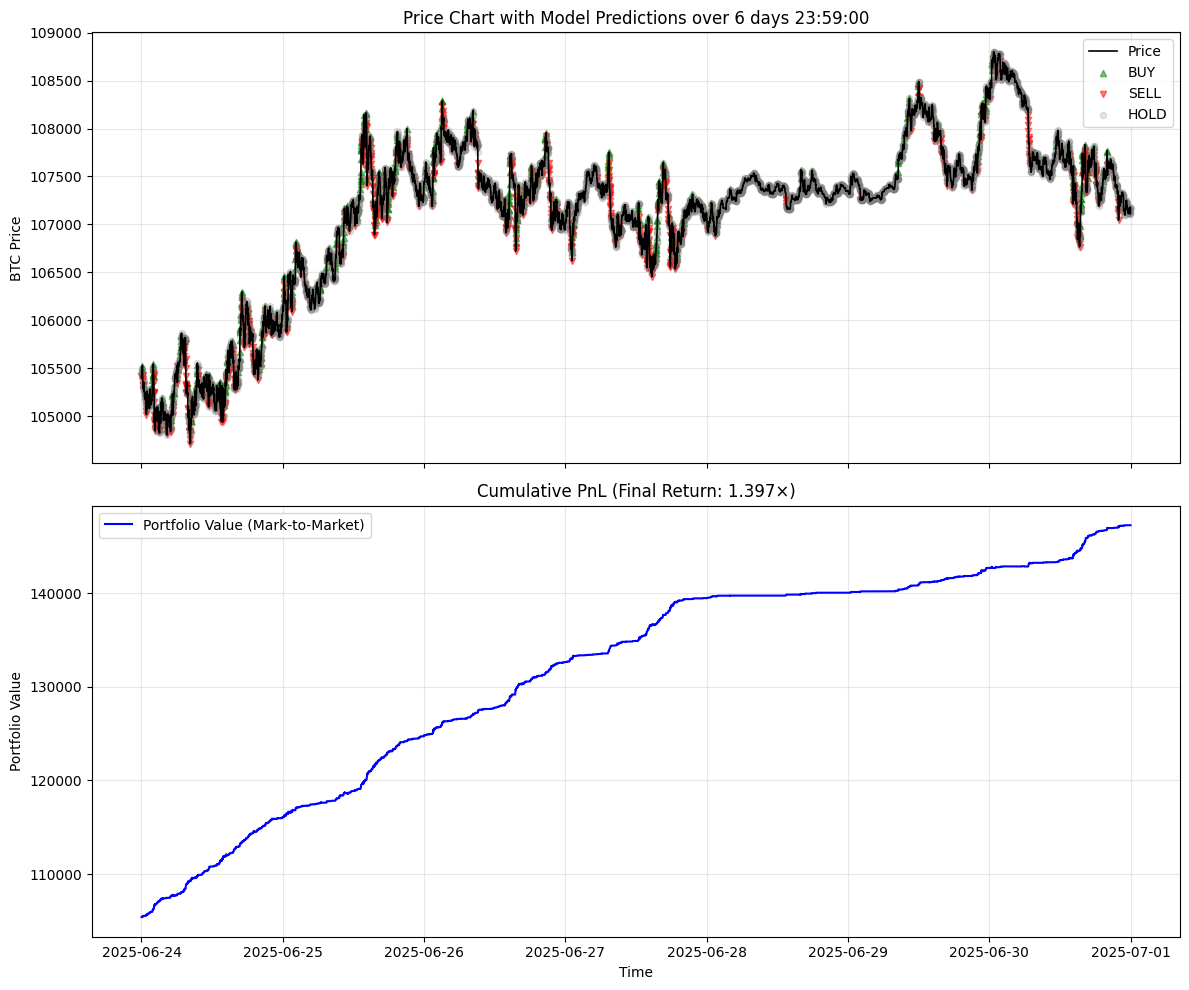

Final strategy multiplier: 1.3971×


In [46]:
plot_smooth_target_vs_price(df_model.iloc[-10080:])

1.4 Times Returns in 1 Week !